## Суворов Роман ИВТ 2.1


## 1. Понимание бизнес-задачи (Business Understanding)

**Цель:** Провести сегментацию клиентов интернет-магазина на основе RFM-признаков (Recency, Frequency, Monetary) для выявления групп с разными шаблонами покупательского поведения и разработки целевых маркетинговых стратегий.

In [33]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для кластеризации и предобработки
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
sns.set_style('whitegrid') # Стиль для графиков

## 2. Понимание данных (Data Understanding)

На этом этапе мы загрузим и изучим предоставленные данные, их структуру, качество и распределения.

### 2.1 Загрузка данных и структура таблицы

In [34]:
# TODO: загрузите данные из файла CSV в DataFrame
# Исходные данные: Файл customer_segmentation_project.csv
try:
    data = pd.read_csv('customer_segmentation_project.csv', encoding='ISO-8859-1')
except FileNotFoundError:
    print("Ошибка: Файл 'customer_segmentation_project.csv' не найден. Убедитесь, что он находится в правильной директории.")
    # Создадим пустой DataFrame, чтобы код ниже не вызвал ошибку, но дальнейший анализ будет невозможен
    data = pd.DataFrame()
    
# Проверка, если данные загружены успешно
if not data.empty:
    # Общая информация о таблице
    print("Размер данных (строки, столбцы):", data.shape)
    print("\nТипы данных и наличие non-null:")
    data.info()
    # Просмотр первых 5 строк
    print("\nПервые 5 строк данных:")
    print(data.head(5))
else:
    print("Данные не были загружены.")

Размер данных (строки, столбцы): (541909, 8)

Типы данных и наличие non-null:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Первые 5 строк данных:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    53

**Интерпретация `data.info()`:**
Мы видим 8 столбцов. Типы данных соответствуют описанию: числовые (`Quantity`, `UnitPrice`, `CustomerID`), строковые (`object`) для идентификаторов и описаний, и `InvoiceDate` пока тоже `object`. Важно, что `CustomerID` имеет значительно меньше Non-Null значений, чем общее количество строк, что указывает на пропуски.

### 2.2 Первичный обзор данных

In [35]:
if not data.empty:
    # Диапазон дат транзакций: найдем минимальную и максимальную дату
    # Сначала преобразуем InvoiceDate в формат datetime для корректной работы
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    print("Диапазон дат:", data['InvoiceDate'].min(), "до", data['InvoiceDate'].max())

    # Количество уникальных клиентов
    print("Уникальных CustomerID:", data['CustomerID'].nunique())

    # Количество уникальных товаров
    print("Уникальных StockCode:", data['StockCode'].nunique())
    # print("Уникальных Description:", data['Description'].nunique()) # Дополнительно для сравнения

    # Страны
    print("Уникальных стран:", data['Country'].nunique())
    print("\nТоп-5 стран по числу транзакций (строк в данных):")
    print(data['Country'].value_counts().head())

    # Пример транзакции: сколько строк относится к одному номеру счета
    # Выберем первый попавшийся номер счета (невозврат)
    sample_invoice = data['InvoiceNo'].iloc[0] if data.shape[0] > 0 else None
    
    if sample_invoice:
        print(f"\nПример кол-ва позиций в одном заказе (InvoiceNo={sample_invoice}):")
        invoice_rows = data[data['InvoiceNo'] == sample_invoice]
        print(f"{invoice_rows.shape[0]} строк")
        print(invoice_rows.head())
    else:
        print("Нет данных для примера транзакции.")

Диапазон дат: 2010-12-01 08:26:00 до 2011-12-09 12:50:00
Уникальных CustomerID: 4372
Уникальных StockCode: 4070
Уникальных стран: 38

Топ-5 стран по числу транзакций (строк в данных):
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

Пример кол-ва позиций в одном заказе (InvoiceNo=536365):
7 строк
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39

**Выводы по первичному обзору:**
- Данные охватывают период примерно в один год.
- Присутствует несколько тысяч уникальных клиентов и товаров.
- Подавляющее большинство транзакций приходится на одну страну (вероятно, Великобританию).
- Один номер счета (`InvoiceNo`) может соответствовать нескольким строкам, что подтверждает, что каждая строка - это позиция в заказе, а не весь заказ целиком.

### 2.3 Поиск пропусков и дубликатов

In [20]:
if not data.empty:
    # Количество пропусков в каждом столбце
    print("Количество пропусков по столбцам:")
    print(data.isna().sum())

    # Удаление записей без CustomerID или Description (непригодны для RFM)
    print("\nУдаляем записи с пустым CustomerID или Description...")
    initial_rows = data.shape[0]
    # TODO: Удалите строки, где CustomerID или Description пропущены
    data.dropna(subset=['CustomerID', 'Description'], inplace=True)
    print(f"Удалено строк с пустым CustomerID/Description: {initial_rows - data.shape[0]}")

    # Поиск и удаление полных дубликатов строк
    print("\nИщем полные дубликаты...")
    initial_rows = data.shape[0]
    # TODO: Удалите полные дубликаты строк
    data.drop_duplicates(inplace=True)
    print(f"Удалено полных дубликатов: {initial_rows - data.shape[0]}")

    print("\nРазмер данных после очистки пропусков и дубликатов:", data.shape)

Количество пропусков по столбцам:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Удаляем записи с пустым CustomerID или Description...
Удалено строк с пустым CustomerID/Description: 135080

Ищем полные дубликаты...
Удалено полных дубликатов: 5225

Размер данных после очистки пропусков и дубликатов: (401604, 8)


**Выводы по очистке:**
Как и ожидалось, значительное количество строк без `CustomerID` удалено. Также, возможно, удалено небольшое количество полных дубликатов. Размер датасета существенно сократился, но оставшиеся данные более пригодны для RFM-анализа, так как привязаны к конкретным клиентам.

### 2.4 Разведочный анализ: выбросы и аномалии в числовых признаках

In [21]:
if not data.empty:
    print("Статистики Quantity и UnitPrice:")
    print(data[['Quantity','UnitPrice']].describe(percentiles=[0.01,0.05,0.95,0.99]))

    print("\nКоличество строк с Quantity < 0 (возвраты):", (data['Quantity'] < 0).sum())

    print("Количество строк с UnitPrice = 0 (бесплатно):", (data['UnitPrice'] == 0).sum())

    print("\nТоп-5 строк по Quantity:")
    if not data.empty:
        print(data.nlargest(5, 'Quantity')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice']])
    else:
         print("Нет данных для отображения топ-5 по Quantity.")

Статистики Quantity и UnitPrice:
            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000

Количество строк с Quantity < 0 (возвраты): 8872
Количество строк с UnitPrice = 0 (бесплатно): 40

Топ-5 строк по Quantity:
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826     ASSTD DESIGN 3D PAPER STICKERS     12540   
421632    573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121    554868     22197               SMALL POPCORN HOLDER      4300

**Анализ выбросов:**
- Присутствуют транзакции с отрицательным `Quantity`, которые соответствуют возвратам. Их количество значительное.
- Также есть строки с `UnitPrice` равным 0.
- Встречаются экстремально большие значения `Quantity` (например, 80995), что явно является выбросом или оптовой продажей, сильно отличающейся от типичных покупок.

## 3. Подготовка данных (Data Preparation)

Приведем данные в формат, необходимый для RFM-анализа и кластеризации.

### 3.1 Очистка: удаление пропусков и дубликатов
(Уже выполнено в разделе 2.3)

### 3.1 (продолжение) Очистка: удаление Quantity = 0 или UnitPrice = 0

In [22]:
if not data.empty:
    print("Удаляем строки с Quantity=0 или UnitPrice=0...")
    initial_rows = data.shape[0]
    # TODO: Удалите строки, где Quantity равен 0 или UnitPrice равен 0
    data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)].copy() # .copy() чтобы избежать SettingWithCopyWarning
    print(f"Удалено строк с Quantity=0 или UnitPrice=0: {initial_rows - data.shape[0]}")

    print("\nОтрицательных Quantity осталось (возвраты):", (data['Quantity'] < 0).sum())

    print("\nРазмер данных после удаления нулевых Quantity/UnitPrice:", data.shape)
else:
    print("Данные пусты, пропускаем очистку нулевых значений.")

Удаляем строки с Quantity=0 или UnitPrice=0...
Удалено строк с Quantity=0 или UnitPrice=0: 40

Отрицательных Quantity осталось (возвраты): 8872

Размер данных после удаления нулевых Quantity/UnitPrice: (401564, 8)


**Пояснение:** Строки с нулевыми значениями Quantity или UnitPrice не отражают фактическую выручку или покупку в контексте RFM и могут исказить расчет Monetary. Поэтому мы их удалили. Отрицательные Quantity (возвраты) пока оставлены, так как они будут учтены при расчете Monetary.

### 3.2 Обработка возвратов (отрицательных Quantity)

Согласно заданию, отрицательные Quantity (возвраты) остаются в данных и будут учтены при расчете Monetary с отрицательным знаком, уменьшая общую ценность клиента. Это упрощенный подход в рамках данной работы.

### 3.3 Создание признака TotalPrice (общая сумма по строке)

In [23]:
if not data.empty:
    # TODO: Создайте новый столбец 'TotalPrice'
    data['TotalPrice'] = data['UnitPrice'] * data['Quantity']

    print("Средняя сумма по строке (TotalPrice):", round(data['TotalPrice'].mean(), 2))
    print("Общая сумма всех транзакций (TotalPrice.sum()):", round(data['TotalPrice'].sum(), 2))
else:
    print("Данные пусты, пропускаем создание TotalPrice.")

Средняя сумма по строке (TotalPrice): 20.62
Общая сумма всех транзакций (TotalPrice.sum()): 8278519.42


**Пояснение:** `TotalPrice` теперь содержит стоимость каждой товарной позиции, включая возвраты с отрицательным значением. Общая сумма всех транзакций отражает чистую выручку.

### 3.4 Формирование RFM-признаков

In [24]:
if not data.empty:
    # TODO: Преобразуйте InvoiceDate в datetime, если еще не преобразован
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

    # TODO: Определите reference_date
    reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
    print("Референсная дата для Recency:", reference_date)

    # TODO: Создайте sales_data, исключив возвраты (InvoiceNo начинается на 'C')
    sales_data = data[~data['InvoiceNo'].astype(str).str.startswith('C')].copy() # Используем ~ для инверсии условия и .copy()
    if sales_data.empty:
        print("\nВнимание: После удаления возвратов не осталось положительных транзакций для расчета Recency и Frequency!")
        rfm = pd.DataFrame(columns=['CustomerID', 'Recency', 'Frequency', 'Monetary'])
    else:
        # TODO: Сгруппируйте по CustomerID и вычислите Recency и Frequency
        rfm = sales_data.groupby('CustomerID').agg(
            Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
            Frequency=('InvoiceNo', 'nunique')
        ).reset_index()

        # TODO: Сгруппируйте по CustomerID и вычислите Monetary
        monetary = data.groupby('CustomerID').agg(
            Monetary=('TotalPrice', 'sum') # Сумма всех трат (с учетом возвратов)
        ).reset_index()

        # TODO: Объедините rfm и monetary по CustomerID
        rfm = pd.merge(rfm, monetary, on='CustomerID', how='left')

        # TODO: Заполните пропущенные значения после объединения (если они появятся)
        # rfm.fillna({'Recency': np.nan, 'Frequency': 0, 'Monetary': 0}, inplace=True) # Это fillna выглядит странно в контексте left merge от sales_data
        if rfm.isna().sum().sum() > 0:
             print("\nВнимание: После объединения RFM и Monetary обнаружены NaN. Необходимо проверить логику merge/fillna.")
             print(rfm.isna().sum())
             rfm['Frequency'].fillna(0, inplace=True)
             rfm['Monetary'].fillna(0, inplace=True)

        print("\nПример RFM для первых 5 клиентов:")
        print(rfm.head(5))

        print("\nВсего клиентов в RFM таблице:", rfm.shape[0])

        # Проверим, есть ли клиенты с отрицательным Monetary
        print("Есть ли клиенты с отрицательным Monetary?", (rfm['Monetary'] < 0).any())
else:
    print("Данные пусты, пропускаем формирование RFM.")


Референсная дата для Recency: 2011-12-10 12:50:00

Пример RFM для первых 5 клиентов:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1      0.00
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

Всего клиентов в RFM таблице: 4338
Есть ли клиенты с отрицательным Monetary? True


**Пояснение:**
- `Recency` рассчитывается как число дней с последней покупки до дня после последней даты в данных.
- `Frequency` - количество уникальных заказов (не возвратов) на клиента.
- `Monetary` - общая сумма трат клиента (с учетом возвратов как отрицательных значений).

Таблица `rfm` теперь содержит по одной строке для каждого клиента с их RFM-метриками.

### 3.5 Анализ распределений R, F, M и обработка выбросов

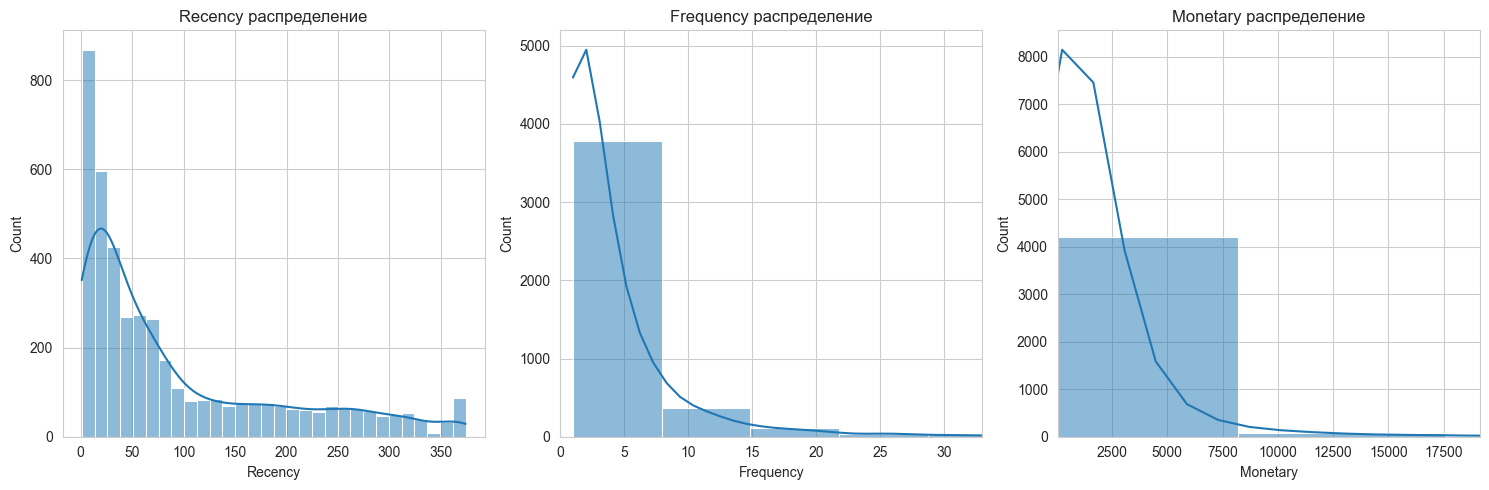


Статистики и перцентили для RFM:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    1910.772398
std     100.014169     7.697998    8248.237548
min       1.000000     1.000000   -1165.300000
1%        1.000000     1.000000      38.697900
5%        3.000000     1.000000     107.930500
10%       5.000000     1.000000     151.713000
25%      18.000000     1.000000     298.027500
50%      51.000000     2.000000     649.955000
75%     142.000000     5.000000    1620.705000
90%     263.000000     9.000000    3516.385000
95%     312.000000    13.000000    5619.928000
99%     369.000000    30.000000   17399.630300
max     374.000000   209.000000  279489.020000


In [25]:
if not rfm.empty:
    # TODO: Постройте гистограммы для Recency, Frequency, Monetary
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(rfm['Recency'], bins=30, kde=True)
    plt.title("Recency распределение")

    plt.subplot(1, 3, 2)
    sns.histplot(rfm['Frequency'], bins=30, kde=True)
    plt.title("Frequency распределение")
    plt.xlim(0, rfm['Frequency'].quantile(0.99) * 1.1) 

    plt.subplot(1, 3, 3)
    sns.histplot(rfm['Monetary'], bins=30, kde=True)
    plt.title("Monetary распределение")
    plt.xlim(rfm['Monetary'].quantile(0.01) * 1.1, rfm['Monetary'].quantile(0.99) * 1.1) 
    

    plt.tight_layout()
    plt.show()

    print("\nСтатистики и перцентили для RFM:")
    print(rfm[['Recency','Frequency','Monetary']].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95,0.99]))
else:
    print("RFM данные пусты, пропускаем анализ распределений.")

**Анализ распределений и выбросов:**
Гистограммы и статистика подтверждают, что Frequency и Monetary сильно скошены вправо, с небольшим количеством клиентов, имеющих очень высокие значения. Recency распределен более равномерно, но также со сдвигом вправо (много клиентов давно не покупали). Присутствуют также клиенты с отрицательным Monetary (возвраты превысили покупки).

Согласно заданию, мы удалим клиентов с экстремально высокими значениями Frequency и Monetary, чтобы они не влияли на центроиды кластеров K-Means.

In [26]:
if not rfm.empty:
    freq_threshold = 30
    monetary_threshold = 20000

    # TODO: Создайте rfm_filtered, удалив выбросы
    rfm_filtered = rfm[
        (rfm['Frequency'] <= freq_threshold) & 
        (rfm['Monetary'] <= monetary_threshold)
    ].copy()

    print(f"Удалено клиентов-выбросов (Frequency > {freq_threshold} или Monetary > {monetary_threshold}): {rfm.shape[0] - rfm_filtered.shape[0]}")

    print("Оставшихся клиентов после фильтрации:", rfm_filtered.shape[0])
    print("\nСтатистики RFM после фильтрации:")
    print(rfm_filtered[['Recency','Frequency','Monetary']].describe())
else:
    print("RFM данные пусты, пропускаем фильтрацию выбросов.")

Удалено клиентов-выбросов (Frequency > 30 или Monetary > 20000): 59
Оставшихся клиентов после фильтрации: 4279

Статистики RFM после фильтрации:
           Recency    Frequency      Monetary
count  4279.000000  4279.000000   4279.000000
mean     93.581912     3.697125   1330.778984
std     100.088118     4.029330   1947.734380
min       1.000000     1.000000  -1165.300000
25%      18.000000     1.000000    294.270000
50%      52.000000     2.000000    640.500000
75%     144.500000     4.000000   1544.880000
max     374.000000    30.000000  18793.410000


**Пояснение:** Мы исключили небольшую группу клиентов с крайне высоким Frequency или Monetary. Эти клиенты могли бы исказить результаты кластеризации основной массы покупателей. Исключенные клиенты могут быть проанализированы отдельно как VIP-сегмент.

### 3.6 Стандартизация признаков RFM

Перед применением K-Means стандартизируем признаки, чтобы они имели одинаковый масштаб (среднее 0, стандартное отклонение 1). Это предотвратит доминирование признаков с большим диапазоном значений (например, Monetary) над признаками с меньшим диапазоном (например, Frequency).

In [27]:
if not rfm_filtered.empty:
    # TODO: Стандартизируйте признаки Recency, Frequency, Monetary
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency','Frequency','Monetary']])

    print("Первые 5 строк стандартизированных RFM признаков (numpy-массив):")
    print(rfm_scaled[:5])
    print("\nРазмер стандартизированных данных:", rfm_scaled.shape)
else:
    print("Отфильтрованные RFM данные пусты, пропускаем стандартизацию.")

Первые 5 строк стандартизированных RFM признаков (numpy-массив):
[[ 2.32240605 -0.6694514  -0.68332444]
 [-0.91511976  0.81980389  1.52976157]
 [-0.18567722  0.07517624  0.23951702]
 [-0.74524958 -0.6694514   0.21913711]
 [ 2.16252823 -0.6694514  -0.51161772]]

Размер стандартизированных данных: (4279, 3)


**Пояснение:** Теперь `rfm_scaled` содержит стандартизированные значения RFM для каждого клиента, готовые для алгоритмов кластеризации, чувствительных к масштабу признаков.


Корреляционная матрица RFM признаков (после фильтрации выбросов):


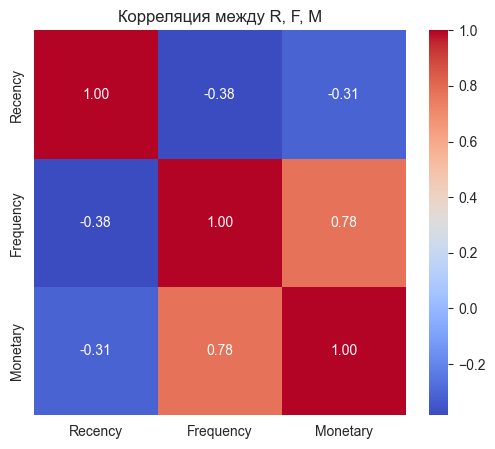

In [28]:
if not rfm_filtered.empty:
    print("\nКорреляционная матрица RFM признаков (после фильтрации выбросов):")
    corr_matrix = rfm_filtered[['Recency','Frequency','Monetary']].corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляция между R, F, M")
    plt.show()
else:
    print("Отфильтрованные RFM данные пусты, пропускаем построение матрицы корреляций.")

**Анализ корреляций:**
Ожидаемо, `Frequency` и `Monetary` положительно коррелируют (клиенты, которые чаще покупают, как правило, тратят больше). `Recency` обратно коррелирует с `Frequency` и `Monetary` (клиенты, которые недавно покупали, вероятно, также чаще покупают и больше тратят).

## 4. Моделирование (Modeling)

Применим K-Means кластеризацию к стандартизированным RFM-признакам. Сначала определим оптимальное число кластеров (K).

### 4.1 Выбор числа кластеров (K) для K-Means: метод “локтя” и коэффициент силуэта

/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/arkadijnetot/Documents/projects/3-cours

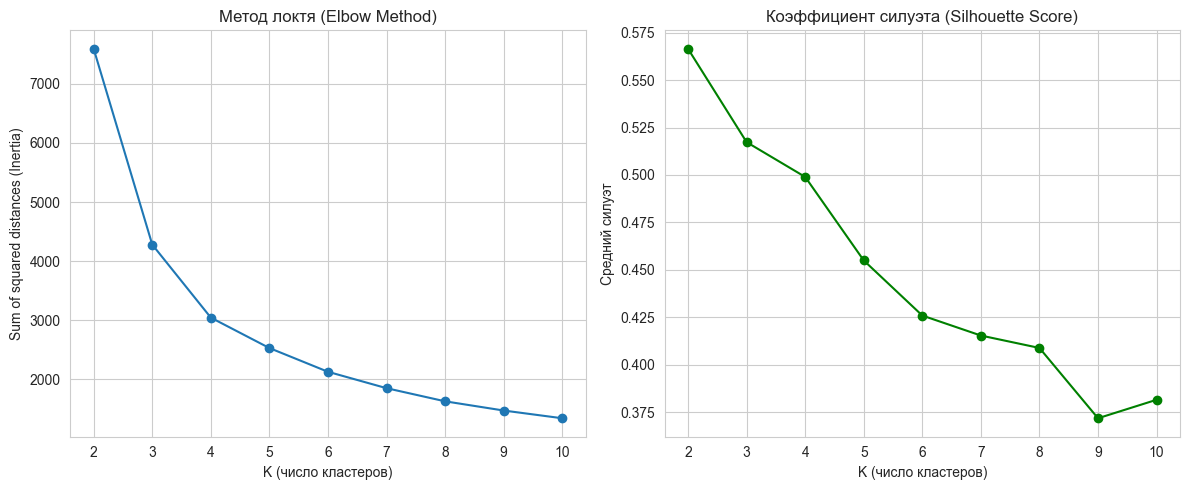

Лучший K по силуэту: 2 с оценкой 0.566


In [29]:
if 'rfm_scaled' in locals() and not rfm_filtered.empty:
    # TODO: Вычислите Inertia и Silhouette Score для разных K
    Ks = range(2, 11) # Диапазон числа кластеров для проверки
    inertias = [] # Список для хранения значений Inertia
    sil_scores = [] # Список для хранения значений Silhouette Score

    for k in Ks:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10) # n_init=10 - запускает K-Means 10 раз с разными центроидами
        kmeans.fit(rfm_scaled) # обучение модели на стандартизированных данных

        inertias.append(kmeans.inertia_)

        labels = kmeans.labels_
        sil_scores.append(silhouette_score(rfm_scaled, labels))

    # TODO: Постройте графики Elbow Method и Silhouette Score
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(list(Ks), inertias, marker='o')
    plt.title("Метод локтя (Elbow Method)")
    plt.xlabel("K (число кластеров)")
    plt.ylabel("Sum of squared distances (Inertia)")

    plt.subplot(1,2,2)
    plt.plot(list(Ks), sil_scores, marker='o', color='green')
    plt.title("Коэффициент силуэта (Silhouette Score)")
    plt.xlabel("K (число кластеров)")
    plt.ylabel("Средний силуэт")

    plt.tight_layout()
    plt.show()

    # TODO: Найдите K с максимальным Silhouette Score
    best_k = Ks[sil_scores.index(max(sil_scores))]
    print("Лучший K по силуэту:", best_k, "с оценкой", round(max(sil_scores), 3))
else:
    print("Стандартизированные RFM данные отсутствуют или пусты, пропускаем выбор K.")

**Анализ графиков:**
- **Метод локтя:** Смотрим на график Inertia. Ищем 'излом' или 'колено' на кривой, где темп снижения Inertia существенно замедляется. Это значение K может быть хорошим кандидатом.
- **Коэффициент силуэта:** Ищем максимум на графике Silhouette Score. K, соответствующий максимальному силуэту, считается оптимальным, так как он указывает на наилучшее разделение кластеров (объекты хорошо соответствуют своим кластерам и плохо соответствуют соседним).

На основе обоих методов (и отдавая предпочтение силуэту как более формальной метрике) выбирается оптимальное число кластеров $K$.

## 4.2 Применение K-Means с оптимальным K

In [30]:
if 'rfm_scaled' in locals() and not rfm_filtered.empty and 'best_k' in locals():
    # TODO: Примените K-Means с best_k к стандартизированным данным
    final_kmeans_model = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
    final_kmeans_model.fit(rfm_scaled)

    cluster_labels = final_kmeans_model.labels_

    # TODO: Добавьте столбец с метками кластеров в rfm_filtered
    rfm_filtered['Cluster'] = cluster_labels

    print(f"Применение K-Means с K = {best_k} завершено.")
    print("\nПервые 5 клиентов с добавленными метками кластеров:")
    print(rfm_filtered.head())
else:
     print("Не удалось применить K-Means. Проверьте наличие и заполненность стандартизированных RFM данных и определенного best_k.")

Применение K-Means с K = 2 завершено.

Первые 5 клиентов с добавленными метками кластеров:
   CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      326          1      0.00        0
1     12347.0        2          7   4310.00        1
2     12348.0       75          4   1797.24        0
3     12349.0       19          1   1757.55        0
4     12350.0      310          1    334.40        0


/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/arkadijnetot/Documents/projects/3-course/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/arkadijnetot/Documents/projects/3-cours

## 5. Оценка (Evaluation)

На этапе оценки мы анализируем характеристики полученных кластеров и интерпретируем их с точки зрения бизнеса. Это позволяет понять, что представляют собой выделенные сегменты клиентов.

### 5.1 Анализ характеристик кластеров

In [31]:
if 'rfm_filtered' in locals() and not rfm_filtered.empty and 'Cluster' in rfm_filtered.columns:
    # TODO: Сгруппируйте rfm_filtered по Cluster и вычислите средние RFM-значения
    cluster_characteristics = rfm_filtered.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

    cluster_characteristics_sorted = cluster_characteristics.sort_values(by='Recency', ascending=True)

    print("\nСредние RFM значения для каждого кластера (отсортировано по Recency):")
    print(cluster_characteristics_sorted)

    cluster_sizes = rfm_filtered['Cluster'].value_counts().sort_index()
    print("\nРазмеры кластеров:")
    print(cluster_sizes)
else:
     print("Не удалось провести анализ характеристик кластеров. Проверьте наличие rfm_filtered с колонкой 'Cluster'.")


Средние RFM значения для каждого кластера (отсортировано по Recency):
            Recency  Frequency     Monetary
Cluster                                    
1         20.136961  11.996248  5144.543508
0        104.032034   2.516284   788.137102

Размеры кластеров:
Cluster
0    3746
1     533
Name: count, dtype: int64


### 5.2 Визуализация кластеров

Визуализация помогает лучше понять, как кластеры расположены в 3D-пространстве RFM. Поскольку у нас 3 признака, можно построить 3D-скаттерплот или парные 2D-графики.

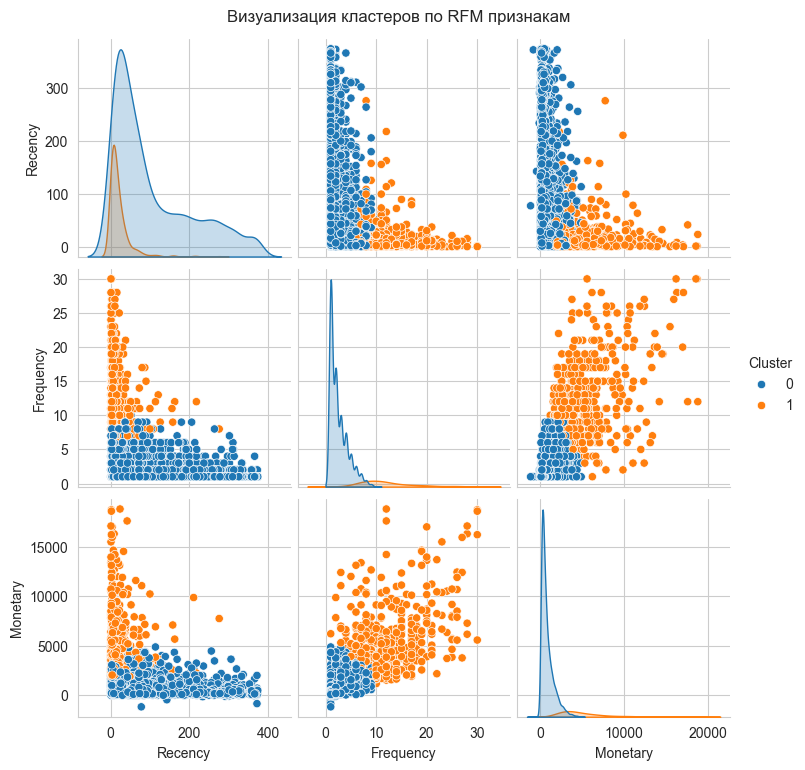

In [32]:
if 'rfm_filtered' in locals() and not rfm_filtered.empty and 'Cluster' in rfm_filtered.columns:
    # TODO: Постройте pairplot или scatter plot для визуализации кластеров


    sns.pairplot(
        rfm_filtered[['Recency', 'Frequency', 'Monetary', 'Cluster']], 
        hue='Cluster', 
        diag_kind='kde' # или 'hist'
    )
    plt.suptitle('Визуализация кластеров по RFM признакам', y=1.02)
    plt.show()
else:
    print("Не удалось визуализировать кластеры. Проверьте наличие rfm_filtered с колонкой 'Cluster'.")

### 5.3 Интерпретация сегментов и рекомендации

На основе средних RFM-значений для каждого кластера (из таблицы `cluster_characteristics_sorted`) и визуализации, мы можем дать названия сегментам и предложить рекомендации.

Примерная интерпретация (зависит от конкретных средних значений каждого кластера):

- **Кластер X (низкий Recency, высокий Frequency, высокий Monetary):** `VIP-клиенты` / `Чемпионы`. Самые ценные клиенты. **Рекомендации:** Программы лояльности, эксклюзивные предложения, ранний доступ к новинкам, особое внимание, сбор обратной связи.

- **Кластер Y (низкий Recency, средний/высокий Frequency, средний/высокий Monetary):** `Лояльные` / `Постоянные покупатели`. Активные, приносят хороший доход. **Рекомендации:** Поддерживать активность, персональные рекомендации, бонусы за повторные покупки, стимулирование кросс-продаж.

- **Кластер Z (средний Recency, низкий Frequency, низкий Monetary):** `Новички` / `Спящие`. Возможно, недавно зарегистрировались или сделали 1-2 покупки и пропали. **Рекомендации:** Приветственные бонусы, онбординг-коммуникации, реактивационные кампании, скидки на первую/вторую покупку, сбор предпочтений.

- **Кластер W (высокий Recency, низкий Frequency, низкий Monetary):** `Уснувшие` / `Риск ухода`. Клиенты, которые давно не покупали и мало тратили. **Рекомендации:** Специальные предложения для возвращения, опросы о причинах ухода, ностальгические кампании, скидки на следующую покупку.

- *Могут быть и другие кластеры, например, 'Большие траты, но редко' (низкий Recency, низкий Frequency, высокий Monetary).* **Рекомендации:** Стимулировать повторные покупки, сообщать о распродажах дорогих товаров.

*Конкретные названия и рекомендации должны быть даны на основе анализа реальных значений RFM для каждого кластера в вашем результате.*

## Выводы

В ходе лабораторной работы была выполнена RFM-сегментация покупателей интернет-магазина в соответствии с методологией CRISP-DM. На первом этапе данные были загружены, очищены от пропусков, дубликатов и аномальных значений. Затем транзакционная информация была преобразована в RFM-метрики (Recency, Frequency, Monetary) для каждого клиента.  

После анализа распределения признаков и удаления выбросов данные были стандартизированы. Для алгоритма K-Means было подобрано оптимальное количество кластеров с помощью метода "локтя" и анализа силуэтов. На финальном этапе проведена кластеризация, а сегменты клиентов проанализированы на основе средних значений RFM-показателей.  

Полученные кластеры позволяют выделить различные группы покупателей, что может быть полезно маркетинговому отделу для разработки персонализированных стратегий взаимодействия и повышения эффективности рекламных кампаний.